In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools_fast import *
from clustering import cluster, cluster_net
from hc_graph import *

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'CARMPAT'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEW,HFRX Equal Weighted Strategies Index


### Financial data loads and cleaning

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_USD = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), EUR_rate)
hfrx = make_FXHedge(hfrx, EUR_USD)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl").drop('BPCURVW4', axis=1)


In [5]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry
BNPIVMRU,Equity,Reversal
BPCURVW4,MM,Carry
BNPIVCXA,Commodity,Volatility
BNPIAIRT,Bonds,Volatility


In [6]:
prices_all = hfrx.join(bnp,how="left").join(risk_premia,how="left").ffill()
prices_all.corr()[fund_name].sort_values()

BPFXTWD1   -0.836150
SPGSNGP    -0.810626
SPGSCLP    -0.726173
SPGSIAP    -0.660572
BPFXGBP1   -0.592450
BNPIPVUH   -0.531929
SPGSHOP    -0.438195
BPFXEUR1   -0.390060
BPFXJPY1   -0.310100
SPGSBRP    -0.261670
BNPIFIT    -0.255728
BPFXSEK1   -0.214544
SPGSIKP    -0.203607
SPGSGOP    -0.187593
BNPIFBR    -0.183990
BNPIPMUH   -0.168690
BPFXNOK1   -0.095268
SPGSIZP    -0.035777
BPFXCZK1   -0.001923
BPFXKRW1    0.052870
BPFXMXN1    0.073270
BPFXZAR1    0.146745
SPGSHUP     0.154890
BPFXCAD1    0.165169
BNPIFJT     0.293856
BPFXPLN1    0.314777
BNPIFRU     0.361465
BNPIPQUH    0.370480
BNPIFSG     0.373410
BPFXHUF1    0.381911
              ...   
BNPXCEB5    0.876744
BNPIFGE     0.879459
BNPIAIRU    0.880588
BNPILUEE    0.881367
BNPIFKR     0.885196
BNPIF3AX    0.885320
BNPIVMRU    0.886290
BNPICCE3    0.890528
BNPXCHY5    0.892206
BNPIFTW     0.892628
BNPIAIRB    0.893453
BNPIPLEE    0.898619
BNPIFHK     0.900928
BNPIFUS2    0.902087
BNPIDRXA    0.903778
BNPIPMEE    0.909701
BNPIFG10    0

In [7]:
prices_all = hfrx.join(bnp,how="left").join(risk_premia,how="left").ffill()
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
prices_all = prices_all.drop(fund_name, axis=1).bfill()

In [8]:
prices_futur = hfrx.join(bnp,how="left")
returns_fut = prices_futur.pct_change().iloc[1:]
hrfx_returns_fut = returns_fut[[fund_name]]
returns_fut = returns_fut.drop(fund_name, axis=1)
prices_futur = prices_futur.drop(fund_name, axis=1).bfill()

In [9]:
prices_risk_premia = hfrx.join(risk_premia,how="left").ffill()
returns_risk_premia = prices_risk_premia.pct_change().iloc[1:]
hrfx_returns_rp = returns_risk_premia[[fund_name]]
returns_risk_premia = returns_risk_premia.drop(fund_name, axis=1)
prices_risk_premia = prices_risk_premia.drop(fund_name, axis=1).bfill()

## Estimation of the exposures

In [10]:
size = 126
freq = 5
freq_ml = 20

### Volatility adjustment

In [11]:
tau = 0.1
tc = 0.0005
nu = 1.0
lag_fut = 2
lag_rp = 3
lag = max(lag_fut, lag_rp)
vol_period = 60


In [12]:
%%time
df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_voladj.index]
df_res_voladj["Kalman VT"] = replication_kalman_voladj

replication_ml_kalman_voladj = make_track(prices_for_track, df_weight_ml_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman VT"] = replication_ml_kalman_voladj

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman AIC VT"] = replication_kalman_aic_voladj

replication_ml_kalman_aic_voladj = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC VT"] = replication_kalman_bic_voladj

replication_ml_kalman_bic_voladj = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj

Wall time: 2min 30s


In [13]:
%%time
df_weight_kalman_aic_voladj_fut = selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj_fut = selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj_fut = ml_selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj_fut = ml_selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj_fut = kalman_filter(hrfx_returns_fut, returns_fut,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj_fut, _ = ml_kalman_filter(hrfx_returns_fut, returns_fut, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_futur.loc[df_weight_kalman_voladj_fut.index[0]:]

replication_kalman_voladj_fut = make_track(prices_for_track, df_weight_kalman_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut = hfrx.loc[replication_kalman_voladj_fut.index]
df_res_voladj_fut["Kalman VT"] = replication_kalman_voladj_fut

replication_ml_kalman_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman VT"] = replication_ml_kalman_voladj_fut

prices_for_track = prices_futur.loc[df_weight_kalman_aic_voladj_fut.index[0]:]

replication_kalman_aic_voladj_fut = make_track(prices_for_track, df_weight_kalman_aic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["Kalman AIC VT"] = replication_kalman_aic_voladj_fut

replication_ml_kalman_aic_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj_fut

replication_kalman_bic_voladj_fut = make_track(prices_for_track, df_weight_kalman_bic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["Kalman BIC VT"] = replication_kalman_bic_voladj_fut

replication_ml_kalman_bic_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj_fut

Wall time: 1min 30s


In [14]:
%%time
df_weight_kalman_aic_voladj_rp = selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj_rp = selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj_rp = ml_selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj_rp = ml_selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj_rp = kalman_filter(hrfx_returns_rp, returns_risk_premia,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj_rp, _ = ml_kalman_filter(hrfx_returns_rp, returns_risk_premia, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_risk_premia.loc[df_weight_kalman_voladj_rp.index[0]:]

replication_kalman_voladj_rp = make_track(prices_for_track, df_weight_kalman_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia = hfrx.loc[replication_kalman_voladj_rp.index]
df_res_voladj_risk_premia["Kalman VT"] = replication_kalman_voladj_rp

replication_ml_kalman_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman VT"] = replication_ml_kalman_voladj_rp

prices_for_track = prices_risk_premia.loc[df_weight_kalman_aic_voladj_rp.index[0]:]

replication_kalman_aic_voladj_rp = make_track(prices_for_track, df_weight_kalman_aic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["Kalman AIC VT"] = replication_kalman_aic_voladj_rp

replication_ml_kalman_aic_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj_rp

replication_kalman_bic_voladj_rp = make_track(prices_for_track, df_weight_kalman_bic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["Kalman BIC VT"] = replication_kalman_bic_voladj_rp

replication_ml_kalman_bic_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj_rp

Wall time: 34.5 s


### All Factors

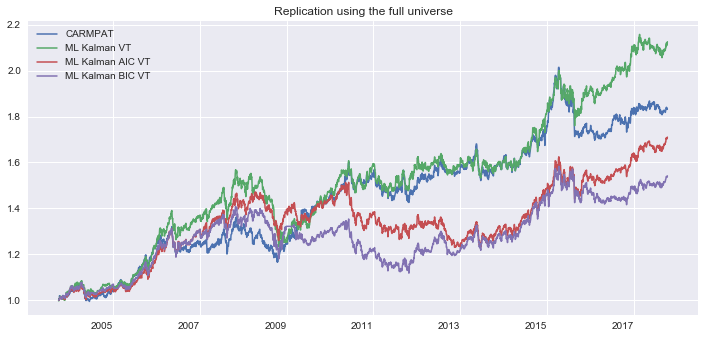

In [15]:
start = '2003'
df_res_voladj = df_res_voladj.dropna().loc[start:'2017-10-13']
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj[[fund_name, 'ML Kalman VT', 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5,
                                                                        title='Replication using the full universe')
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [16]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.562168,0.044047,-0.154378
Kalman VT,0.809138,0.622181,0.052400,0.600975,0.653125,0.053965,-0.189082
ML Kalman VT,0.754378,0.591472,0.059788,0.480519,0.651723,0.054389,-0.213639
Kalman AIC VT,0.750713,0.566617,0.060410,0.469658,0.455074,0.036639,-0.211331
ML Kalman AIC VT,0.755243,0.570743,0.057961,0.511779,0.498552,0.038471,-0.186733
Kalman BIC VT,0.722004,0.525939,0.062956,0.424008,0.344189,0.026128,-0.261650
ML Kalman BIC VT,0.701895,0.530285,0.064326,0.398658,0.406428,0.030910,-0.202256


### Classic Factors

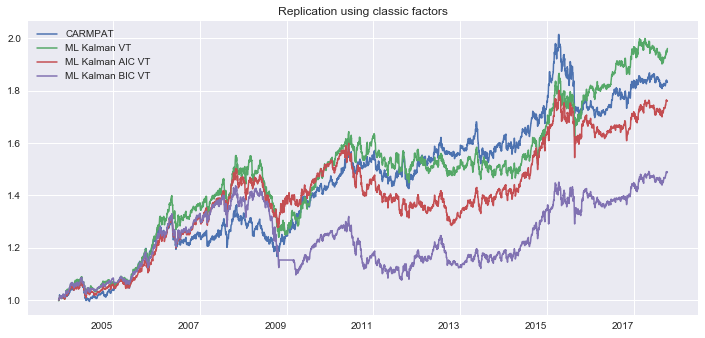

In [17]:
df_res_voladj_fut = df_res_voladj_fut.dropna().loc[start:'2017-10-13']
df_res_voladj_fut = (df_res_voladj_fut / df_res_voladj_fut.iloc[0])
df_res_voladj_fut[[fund_name, 'ML Kalman VT', 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5,
                                                                        title='Replication using classic factors')
df_res_volperfadj_fut = df_res_voladj_fut[[fund_name]].copy()
temp = df_res_voladj_fut.drop(fund_name, axis=1)
df_res_volperfadj_fut[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [18]:
df_stat_vol_fut = replication_stats(df_res_voladj_fut, fund_name=fund_name)
df_stat_vol_fut

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.562168,0.044047,-0.154378
Kalman VT,0.811755,0.617613,0.052950,0.592554,0.663799,0.056368,-0.177271
ML Kalman VT,0.766965,0.585312,0.058862,0.496483,0.577555,0.048362,-0.200906
Kalman AIC VT,0.780385,0.578973,0.056982,0.528132,0.442752,0.035756,-0.199554
ML Kalman AIC VT,0.787419,0.593588,0.055469,0.552858,0.506487,0.040938,-0.195442
Kalman BIC VT,0.715249,0.530322,0.065056,0.384943,0.253205,0.018675,-0.320961
ML Kalman BIC VT,0.712519,0.539597,0.063545,0.413179,0.375844,0.028561,-0.250612


### Risk Premia

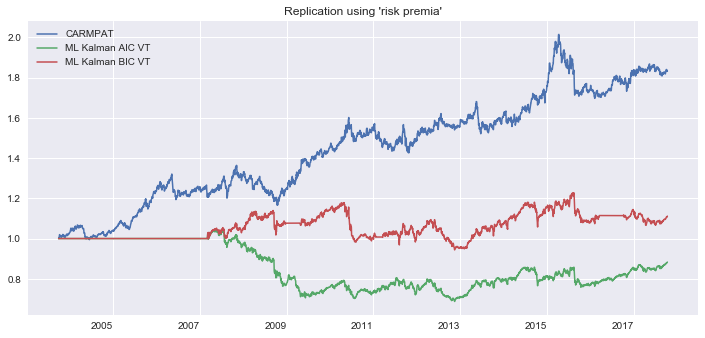

In [19]:
df_res_voladj_risk_premia = df_res_voladj_risk_premia.dropna().loc[start:'2017-10-13']
df_res_voladj_risk_premia = (df_res_voladj_risk_premia / df_res_voladj_risk_premia.iloc[0])
df_res_voladj_risk_premia[[fund_name, 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5,
                                                                        title="Replication using 'risk premia'")
df_res_volperfadj_risk_premia = df_res_voladj_risk_premia[[fund_name]].copy()
temp = df_res_voladj_risk_premia.drop(fund_name, axis=1)
df_res_volperfadj_risk_premia[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [20]:
df_stat_vol_risk_premia = replication_stats(df_res_voladj_risk_premia, fund_name=fund_name)
df_stat_vol_risk_premia

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.562168,0.044047,-0.154378
Kalman VT,0.498197,0.323038,0.079220,0.087966,0.351840,0.023672,-0.201532
ML Kalman VT,0.355122,0.230192,0.093138,-0.260641,-0.392788,-0.034493,-0.479154
Kalman AIC VT,0.420687,0.250264,0.083661,-0.017169,0.156541,0.008639,-0.155419
ML Kalman AIC VT,0.356798,0.251362,0.090767,-0.197282,-0.080048,-0.009070,-0.336994
Kalman BIC VT,0.468145,0.288342,0.080124,0.067036,0.416598,0.027435,-0.152171
ML Kalman BIC VT,0.395393,0.274963,0.086092,-0.077126,0.135085,0.007183,-0.192725


## Volatility Contributions

In [21]:
df_weight_ml_kalman_voladj_ = df_weight_kalman_voladj.loc['2008':'2017-10-13']
df_vol_contrib_ml_kalman_voladj = (prices_all.reindex(df_weight_ml_kalman_voladj_.index).pct_change()*df_weight_ml_kalman_voladj_).std()
df_vol_contrib_ml_kalman_voladj = df_vol_contrib_ml_kalman_voladj/df_vol_contrib_ml_kalman_voladj.sum()

df_weight_ml_kalman_bic_voladj_ = df_weight_ml_kalman_bic_voladj.loc['2008':'2017-10-13']
df_vol_contrib_ml_kalman_bic_voladj = (prices_all.reindex(df_weight_ml_kalman_bic_voladj_.index).pct_change()*df_weight_ml_kalman_bic_voladj_).std()
df_vol_contrib_ml_kalman_bic_voladj = df_vol_contrib_ml_kalman_bic_voladj/df_vol_contrib_ml_kalman_bic_voladj.sum()

df_weight_ml_kalman_aic_voladj_ = df_weight_ml_kalman_aic_voladj.loc['2008':'2017-10-13']
df_vol_contrib_ml_kalman_aic_voladj = (prices_all.reindex(df_weight_ml_kalman_aic_voladj_.index).pct_change()*df_weight_ml_kalman_aic_voladj_).std()
df_vol_contrib_ml_kalman_aic_voladj = df_vol_contrib_ml_kalman_aic_voladj/df_vol_contrib_ml_kalman_aic_voladj.sum()

In [22]:
vol_contrib = pd.DataFrame()
vol_contrib['ML Kalman VT'] = df_vol_contrib_ml_kalman_voladj
vol_contrib["ML Kalman AIC VT"] = df_vol_contrib_ml_kalman_aic_voladj
vol_contrib["ML Kalman BIC VT"] = df_vol_contrib_ml_kalman_bic_voladj
vol_contrib = vol_contrib.join(df_info).reset_index()

In [23]:
vol_contrib_asset_class = vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
vol_contrib_style = vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [24]:
repli = "ML Kalman VT"
g = hc_piechart(vol_contrib_asset_class[[repli]], title="Vol contribution by Asset Class in " + repli)
g.plot()

In [25]:
g = hc_piechart(vol_contrib_style[[repli]], title="Vol contribution by Style in " + repli)
g.plot()

## Performance contributions

In [26]:
perf_contrib_ml_kalman_voladj = (1 + prices_all.reindex(df_weight_ml_kalman_voladj_.index).pct_change()*df_weight_ml_kalman_voladj_).prod() - 1
perf_contrib_ml_kalman_bic_voladj = (1 + prices_all.reindex(df_weight_ml_kalman_bic_voladj_.index).pct_change()*df_weight_ml_kalman_bic_voladj_).prod() - 1
perf_contrib_ml_kalman_aic_voladj = (1 + prices_all.reindex(df_weight_ml_kalman_aic_voladj_.index).pct_change()*df_weight_ml_kalman_aic_voladj_).prod() - 1

In [27]:
perf_contrib = pd.DataFrame()
perf_contrib["ML Kalman VT"] = perf_contrib_ml_kalman_voladj
perf_contrib["ML Kalman AIC VT"] = perf_contrib_ml_kalman_aic_voladj
perf_contrib["ML Kalman BIC VT"] = perf_contrib_ml_kalman_bic_voladj
perf_contrib = perf_contrib.join(df_info).reset_index()

In [28]:
perf_contrib_asset_class = perf_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
perf_contrib_style = perf_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [29]:
g = hc_spiderweb(perf_contrib_asset_class, title="Performance contribution by Asset Class")
g.plot()

In [30]:
g = hc_spiderweb(perf_contrib_style, title="Performance contribution by Style")
g.plot()

## plt charts

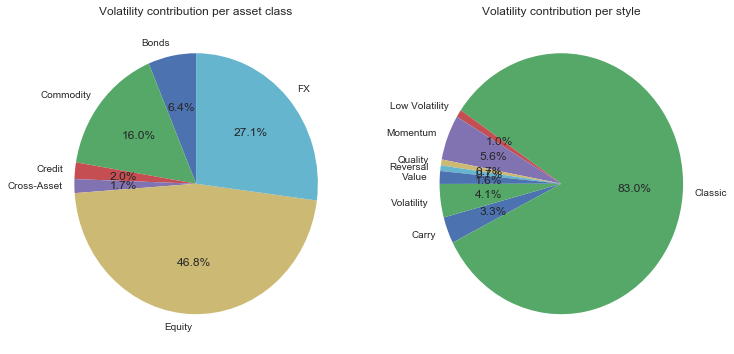

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
vol_contrib_asset_class.groupby(level=0).sum().plot(kind='pie', y=repli, legend=False, autopct='%1.1f%%', ax=ax1,
                                              title='Volatility contribution per asset class', startangle=90)
ax1.set_ylabel('')
vol_contrib_style.groupby(level=0).sum().plot(kind='pie', y=repli, legend=False, autopct='%1.1f%%', ax=ax2,
                                              title='Volatility contribution per style', startangle=195)
_ = ax2.set_ylabel('')

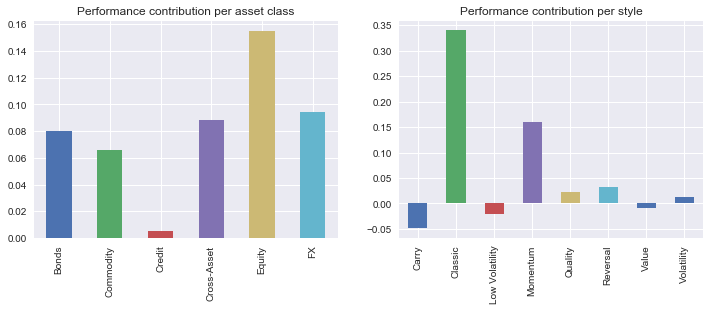

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
perf_contrib_asset_class[repli].groupby(level=0).sum().plot(kind='bar', ax=ax1,
                                                     title='Performance contribution per asset class')
ax1.set_xlabel('')
perf_contrib_style[repli].groupby(level=0).sum().plot(kind='bar', ax=ax2,
                                                     title='Performance contribution per style')
_ = ax2.set_xlabel('')